In [1]:
#%% markdown

#Name: Suman Raman Poudel
#Course Title: MSCS 634: Data Mining
# Lab Assignment: Classification, Clustering, and Association Rule Mining



In [2]:
## Step 1: Data Preparation and Loading

### Dataset Selection
# Using the **Online Retail Dataset** from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Online+Retail). This dataset contains transactional data with customer purchases, suitable for classification (predicting high-value customers), clustering, and association rule mining.

### Loading and Cleaning
# - Load from URL.
# - Clean missing values, cancellations, and prepare features for classification/clustering.

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import combinations
from collections import Counter
import time
import random

# Load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

# Cleaning
df = df.dropna(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'CustomerID'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]
df['Description'] = df['Description'].str.strip().str.lower()

# Feature engineering for classification: Target = High-Value Customer (based on total spend)
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']
customer_spend = df.groupby('CustomerID')['TotalSpend'].sum()
threshold = customer_spend.quantile(0.75)
df['IsHighValue'] = df['CustomerID'].map(lambda x: 1 if customer_spend[x] >= threshold else 0)

# Build transactions mapping
transactions_by_invoice = df.groupby('InvoiceNo')['Description'].apply(lambda s: list(set(s))).to_dict()

# Sample invoices safely
random.seed(42)
all_invoices = list(transactions_by_invoice.keys())
sample_size = min(200, len(all_invoices))
assert sample_size > 0, "No invoices available after cleaning."
sampled_invoices = random.sample(all_invoices, sample_size)

# Sampled transactions
transactions_sample = [transactions_by_invoice[i] for i in sampled_invoices]

# Filter dataframe
df_sample = df[df['InvoiceNo'].isin(sampled_invoices)].copy()

# Print stats
print(f"Sample size (transactions): {len(transactions_sample)}")
print(f"Sampled dataframe rows: {len(df_sample)}")
print(f"Number of unique items in sample: {len(set(item for trans in transactions_sample for item in trans))}")

Sample size (transactions): 200
Sampled dataframe rows: 4189
Number of unique items in sample: 1605


In [5]:
### Visualizations for Initial Exploration
# - Barplot: Top 20 frequent items.
# - Heatmap: Co-occurrences (top 20).

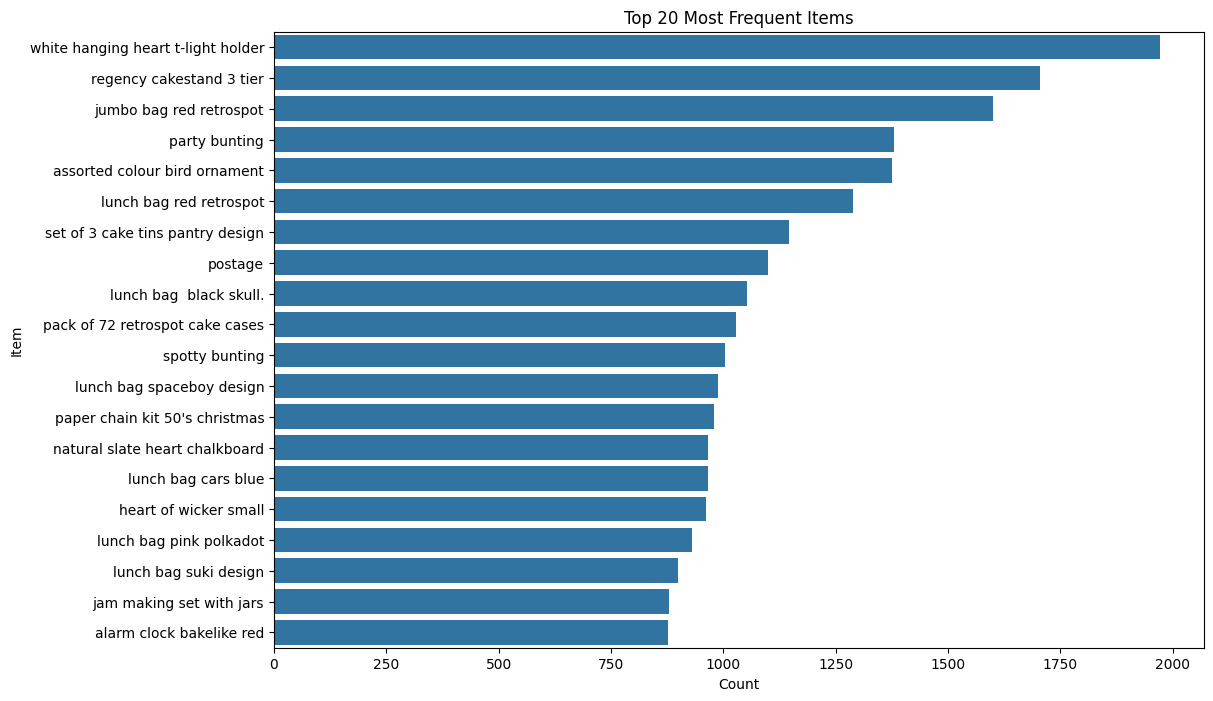

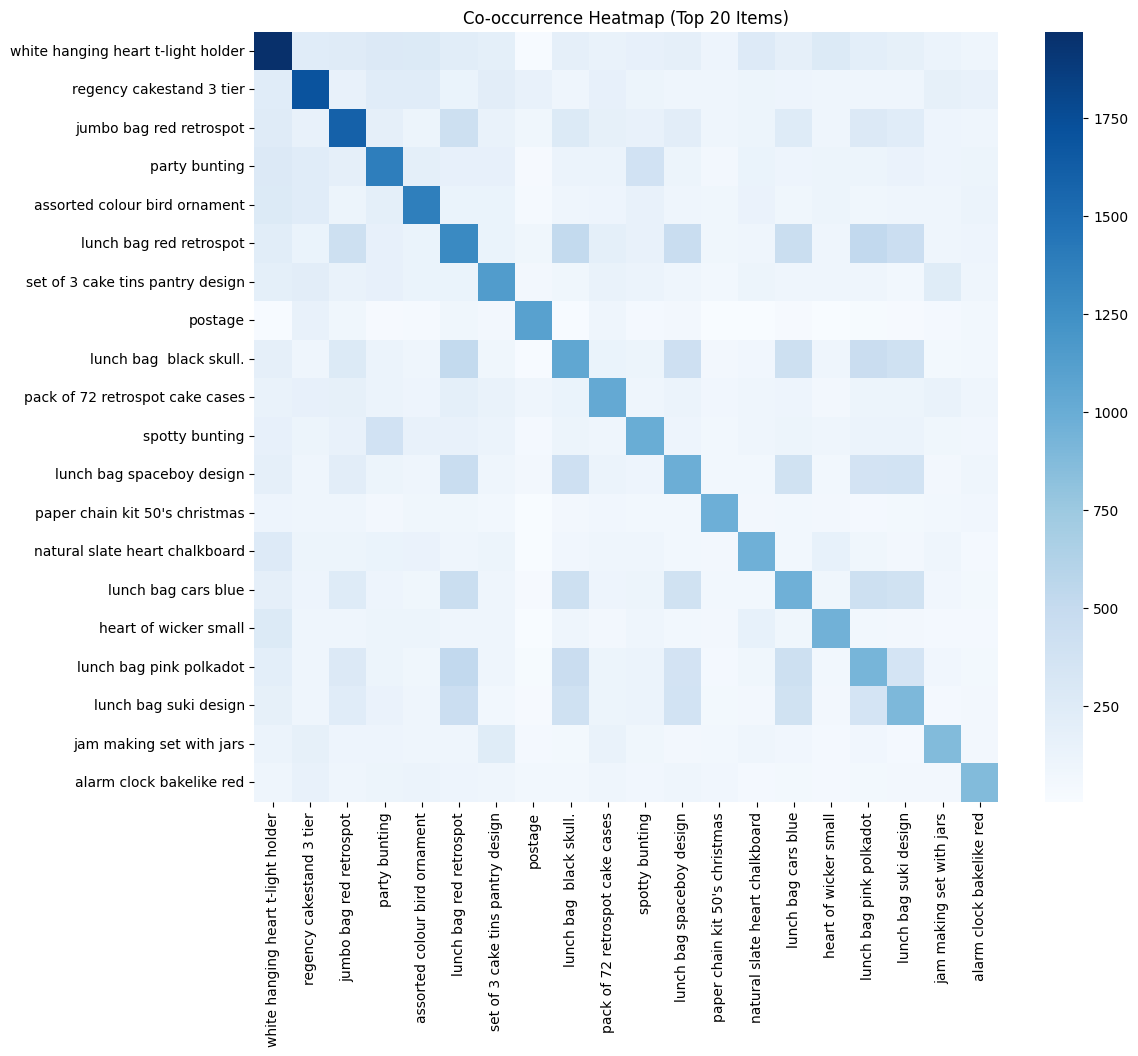

In [6]:
# Item frequencies
item_counts = Counter(item for transaction in transactions for item in transaction)
df_counts = pd.DataFrame(list(item_counts.items()), columns=['Item', 'Count']).sort_values('Count', ascending=False).head(20)

# Barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Item', data=df_counts)
plt.title('Top 20 Most Frequent Items')
plt.show()

# Co-occurrence (top 20)
top_items = df_counts['Item'].tolist()
df_onehot = pd.DataFrame(0, index=range(len(transactions)), columns=top_items)
for i, trans in enumerate(transactions):
    for item in trans:
        if item in top_items:
            df_onehot.loc[i, item] = 1
co_occ = df_onehot.T.dot(df_onehot)
plt.figure(figsize=(12, 10))
sns.heatmap(co_occ, annot=False, cmap='Blues')
plt.title('Co-occurrence Heatmap (Top 20 Items)')
plt.show()

In [7]:
### Prepare Data for Classification
# - Features: Quantity, UnitPrice.
# - Target: IsHighValue.
# - Stratify split to maintain class balance.

In [8]:
# Features & target
X = df_sample[['Quantity', 'UnitPrice']]
y = df_sample['IsHighValue']

# Check class balance
if y.nunique() < 2:
    raise ValueError("Target has a single class after sampling; adjust sampling or threshold.")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
## Step 2: Classification Model Development

### Develop Two Models: Decision Tree and k-NN

In [12]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)

# k-NN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

In [13]:
### Hyperparameter Tuning for Decision Tree
#Using GridSearchCV to tune max_depth and min_samples_split.

In [14]:
# Hyperparameter tuning
param_grid = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_dt_model = grid_search.best_estimator_
best_dt_pred = best_dt_model.predict(X_test_scaled)

Best parameters: {'max_depth': 5, 'min_samples_split': 5}


In [15]:
### Evaluate Models
#- Confusion Matrix, ROC Curve, Accuracy/F1 Score.

Decision Tree - Accuracy: 0.64, F1: 0.73
Tuned Decision Tree - Accuracy: 0.62, F1: 0.72
k-NN - Accuracy: 0.62, F1: 0.71


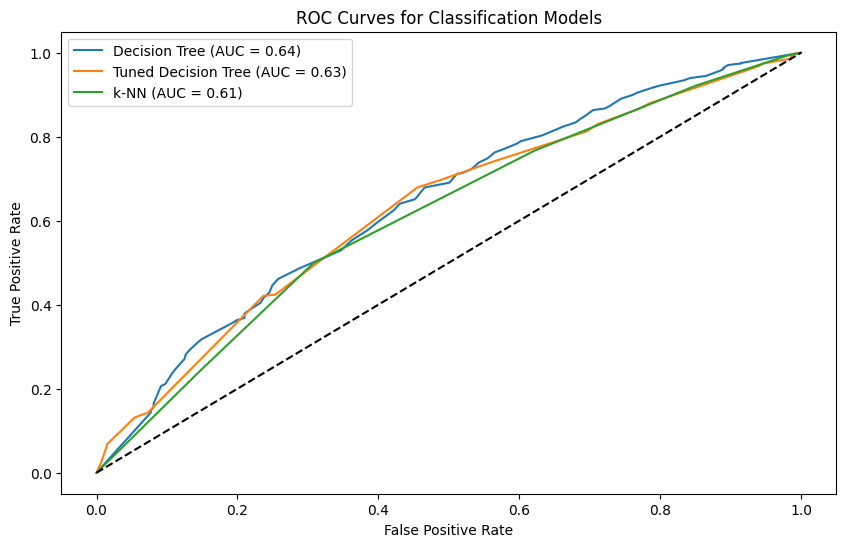

In [16]:
# Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_pred)
cm_best_dt = confusion_matrix(y_test, best_dt_pred)
cm_knn = confusion_matrix(y_test, knn_pred)

# ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_model.predict_proba(X_test_scaled)[:, 1])
fpr_best_dt, tpr_best_dt, _ = roc_curve(y_test, best_dt_model.predict_proba(X_test_scaled)[:, 1])
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])

# Scores
acc_dt = accuracy_score(y_test, dt_pred)
f1_dt = f1_score(y_test, dt_pred)
acc_best_dt = accuracy_score(y_test, best_dt_pred)
f1_best_dt = f1_score(y_test, best_dt_pred)
acc_knn = accuracy_score(y_test, knn_pred)
f1_knn = f1_score(y_test, knn_pred)

print(f"Decision Tree - Accuracy: {acc_dt:.2f}, F1: {f1_dt:.2f}")
print(f"Tuned Decision Tree - Accuracy: {acc_best_dt:.2f}, F1: {f1_best_dt:.2f}")
print(f"k-NN - Accuracy: {acc_knn:.2f}, F1: {f1_knn:.2f}")

# Visualize ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc(fpr_dt, tpr_dt):.2f})')
plt.plot(fpr_best_dt, tpr_best_dt, label=f'Tuned Decision Tree (AUC = {auc(fpr_best_dt, tpr_best_dt):.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUC = {auc(fpr_knn, tpr_knn):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for Classification Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [18]:
## Step 3: Clustering Model Development

### Develop K-Means Clustering

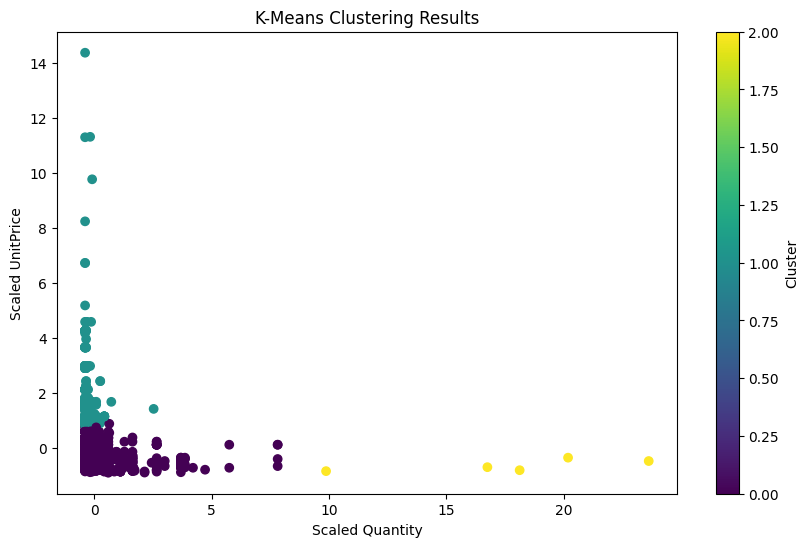

In [19]:
# K-Means on scaled features
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)
labels = kmeans.predict(X_train_scaled)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=labels, cmap='viridis')
plt.title('K-Means Clustering Results')
plt.xlabel('Scaled Quantity')
plt.ylabel('Scaled UnitPrice')
plt.colorbar(label='Cluster')
plt.show()

In [20]:
## Step 4: Association Rule Mining

### Apply FP-Growth

In [21]:
# FP-Node class and functions
class FPNode:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}
        self.next = None

def update_header(header_table, target_node):
    if header_table[target_node.item][1] is None:
        header_table[target_node.item][1] = target_node
    else:
        current = header_table[target_node.item][1]
        while current.next: current = current.next
        current.next = target_node

def update_tree(items, tree, header_table, count):
    if items[0] in tree.children:
        tree.children[items[0]].count += count
    else:
        new_node = FPNode(items[0], count, tree)
        tree.children[items[0]] = new_node
        update_header(header_table, new_node)
    if len(items) > 1:
        update_tree(items[1:], tree.children[items[0]], header_table, count)

def create_tree(transactions, min_support_count):
    header_table = {}
    for t in transactions:
        for item in t:
            header_table[item] = header_table.get(item, 0) + 1
    header_table = {k: [v, None] for k, v in header_table.items() if v >= min_support_count}
    if not header_table: return None, None
    root = FPNode('Null', 1, None)
    for t in transactions:
        filtered = [i for i in t if i in header_table]
        if filtered:
            filtered.sort(key=lambda x: header_table[x][0], reverse=True)
            update_tree(filtered, root, header_table, 1)
    return root, header_table

def get_prefix_path(item, header_table):
    current = header_table[item][1]
    paths = []
    while current:
        path = []
        node = current.parent
        while node.item != 'Null':
            path.append(node.item)
            node = node.parent
        if path: paths.append((path[::-1], current.count))
        current = current.next
    return paths

def mine_tree(header_table, min_support_count, prefix, freq_list):
    items = sorted(header_table.keys(), key=lambda x: header_table[x][0])
    for item in items:
        new_freq = prefix.copy()
        new_freq.add(item)
        freq_list.append(new_freq)
        paths = get_prefix_path(item, header_table)
        tree, new_header = create_tree([p[0] for p in paths], min_support_count)
        if new_header: mine_tree(new_header, min_support_count, new_freq, freq_list)

def find_frequent_itemsets(transactions, min_support_count):
    tree, header_table = create_tree(transactions, min_support_count)
    freq_list = []
    mine_tree(header_table, min_support_count, set(), freq_list)
    return freq_list

# Run FP-Growth
min_support_count = 10
start_time = time.time()
freq_itemsets = find_frequent_itemsets(transactions_sample, min_support_count)
fpgrowth_time = time.time() - start_time
print(f"FP-Growth execution time: {fpgrowth_time:.4f} seconds")

# Compute support
freq_with_support = []
for itemset in freq_itemsets:
    count = sum(1 for trans in transactions_sample if all(i in trans for i in itemset))
    freq_with_support.append((list(itemset), count / len(transactions_sample)))

# Display top 10
print("\nTop 10 Frequent Itemsets (support):")
for itemset, supp in sorted(freq_with_support, key=lambda x: -x[1])[:10]:
    print(f"{itemset}: {supp:.4f}")

FP-Growth execution time: 0.0156 seconds

Top 10 Frequent Itemsets (support):
['jumbo bag red retrospot']: 0.1300
['regency cakestand 3 tier']: 0.1050
['party bunting']: 0.0850
['lunch bag red retrospot']: 0.0850
['set of 3 cake tins pantry design']: 0.0800
['white hanging heart t-light holder']: 0.0800
['spotty bunting']: 0.0750
['jumbo bag pink polkadot']: 0.0750
['lunch bag pink polkadot']: 0.0700
['jumbo storage bag suki']: 0.0700


In [22]:
### Generate Association Rules

In [23]:
# Support dict
support_dict = {frozenset(s): v for s, v in freq_with_support}
min_conf = 0.6

rules = []
for itemset, supp in freq_with_support:
    if len(itemset) > 1:
        for r in range(1, len(itemset)):
            for ante in combinations(itemset, r):
                ante_set = frozenset(ante)
                conse_set = frozenset(itemset) - ante_set
                conf = supp / support_dict[ante_set]
                if conf >= min_conf:
                    lift = supp / (support_dict[ante_set] * support_dict[conse_set])
                    rules.append((list(ante_set), list(conse_set), supp, conf, lift))

print("\nAssociation Rules:")
for ante, conse, supp, conf, lift in sorted(rules, key=lambda x: -x[3]):
    print(f"{ante} -> {conse} (support: {supp:.4f}, confidence: {conf:.4f}, lift: {lift:.4f})")


Association Rules:
['lunch bag  black skull.'] -> ['lunch bag pink polkadot'] (support: 0.0550, confidence: 0.9167, lift: 13.0952)
['lunch bag pink polkadot'] -> ['lunch bag  black skull.'] (support: 0.0550, confidence: 0.7857, lift: 13.0952)
